# Data4Good Case Challenge



![Data4Good](Data4Good.png)



## 📖 Background
Artificial Intelligence (AI) is rapidly transforming education by providing students with instant access to information and adaptive learning tools. Still, it also introduces significant risks, such as the spread of misinformation and fabricated content. Research indicates that large language models (LLMs) often confidently generate factually incorrect or “hallucinated” responses, which can mislead learners and erode trust in digital learning platforms. 

The 4th Annual Data4Good Competition challenges participants to develop innovative analytics solutions to detect and improve factuality in AI-generated educational content, ensuring that AI advances knowledge rather than confusion.

## 💾 The data

The data provided is a Questions/Answer dataset to determine if the answer is factual, not factual (contradiction), or irrelevant to the question.


- Question: The question asked/prompted for
- Context: Relevant contextual support for the question
- Answer: The answer provided by an AI
- Type:  A categorical variable with three possible levels – Factual, Contradiction, Irrelevant:
  - Factual: the answer is correct
  - Contradiction: the answer is incorrect
  - Irrelevant: the answer has nothing to do with the question
  
There are 21,021 examples in the dataset (`data/train.json`) that you will experiment with. 


The test dataset (`data/test.json`) contains 2000 examples that you predict as one of the three provided classes. In addition to classification performance we are seeking as detailed as possible methodologies of your step-by-step approach in your notebooks. Discuss what worked well, what did not work well, and your suggestions or ideas if a general approach to these types of problems might exist.


### Previewing the Training Data

Let's load and preview the `train.json` dataset to understand its structure and contents.

In [62]:
import pandas as pd
import json

# Load the train.json file
train_data_path = "data/train.json"
with open(train_data_path, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Convert to DataFrame
train_df = pd.DataFrame(train_data)

# Show the first 50 rows
train_df.head(15)

,answer,type,context,question
0,"In 1512, Parliament passed a significant act t...",factual,During the Hundred Years' War a French attack ...,In what year did Parliament pass a notable law...
1,The Spanish and French were the ones who estab...,factual,"""By May 1539, Conquistador Hernando de Soto sk...",Who established early settlements in Florida
2,"Traditionally, monsoons in Punjab are expected...",factual,The onset of the southwest monsoon is anticipa...,When do monsoons traditionally happen in Punjab?
3,The media made the requests for Kondo to use o...,factual,Media requests at the trade show prompted Kond...,Who made the requests for Kondo to use orchest...
4,According to historians Robert Friedel and Pau...,factual,In addressing the question of who invented the...,How many inventors came up with electric lamps...
5,The process that can increase solar energy pot...,factual,,What is the process called that can increase s...
6,The main focus of the 5th season is the Digita...,factual,"After a three-year hiatus, a fifth Digimon ser...",What was the main focus of the 5th season?
7,The mean annual temperature in Hyderabad is 26...,factual,Hyderabad has a tropical wet and dry climate (...,What is the mean yearly temperature in Hyderab...
8,The issue of through traffic benefits can aris...,factual,Network effects are a large factor with electr...,Where can the issue of through traffic benefit...
9,Montini's office received nearly ten million i...,irrelevant,,Fireworks are discharged on New Year's Eve fro...


In [63]:
# Load the train.json file
test_data_path = "data/test.json"
with open(test_data_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Convert to DataFrame
test_df = pd.DataFrame(test_data)

# Show the first 50 rows
test_df.head(15)

,ID,answer,type,context,question
0,1,"In the mid-19th century, the Bronx was referre...",,The Bronx street grid is irregular. Like the n...,What was the Bronx called in the mid-19th cent...
1,2,"Beyoncé's father, Mathew Knowles, began managi...",,,When did Beyoncé begin to manage the girl group?
2,3,Dionysus was similar to the Roman god Bacchus.,,"While the new plebeian nobility made social, p...",To what Roman god was Dionysus similar?
3,4,The most crucial defense in preventing the spr...,,"Techniques like hand washing, wearing gowns, a...",What is the most important defense against the...
4,5,The third largest long term acute care provide...,,The Baylor College of Medicine has annually be...,What is the third largest acute care center in...
5,6,Approximately 50% of all copper that is mined ...,,"Despite competition from other materials, copp...",How much of mined copper is used for cables an...
6,7,The Governing Body consists of seven members.,,Jehovah's Witnesses are organized hierarchical...,How many members does the Governing Body consi...
7,8,"In Japan, the Early Modern period is known as ...",,"The BBC also introduced Ceefax, the first tele...",What is the modern replacement for Ceefax?
8,9,"SI units, such as centimeter (厘米 límǐ) and kil...",,Modern examples particularly include Chinese c...,What are disyllabic and usually written with t...
9,10,Glaciers are referred to as ice sheets or cont...,,"Additionally, Somalia has several private tele...",Howmany governemnt run channels do Puntland an...


In [64]:
# imports for pre-processing and machine learning 

# numerical modules
import numpy as np
import math

# pandas and visualisation modules
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# ML modules
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader

# import metric tests
from torchmetrics import Accuracy
from torchmetrics import Precision
from torchmetrics import Recall


In [65]:
# function to determine a unique number for each word up to words containing same letters 
# i.e. low and owl will have the same number asssigned, but big and small will have a different value.
# non-standard characters will receive a value of 1

def func(sentence: str):
    '''
    Take a sentence and transform it into a list of numbers.
    Each entry in the returned list is the multiplication of prime numbers of each character - thus making the encoding unique up to anagrams. 
    None-standard and uncommon characters receive an encoding of 1. 

    Parameters: 
        sentence (str): the sentence to transform.

    Returns:
        list: the list of numbers corresponding to each word and expression.
    '''

    primes = { 'a' : 2, 'b' : 3, 'c' : 5, 'd' : 7, 'e' : 11, 'f' : 13, 'g' : 17, 'h' : 19, 'i' : 23, 'j' : 29, 'k' : 31,  'l' : 37, 'm' : 41, 'n' : 43, 'o' : 47, 'p' : 53, 'q' : 59, 'r' : 61, 's' : 67, 't' : 71, 'u' : 73, 'v' : 79, 'w' : 83, 'x' : 89, 'y' : 97, 'z' : 101, '.' : 103, ',' : 107, '?' : 109, '£' : 113, '$' : 127, '"' : 131, '-' : 137, '0' : 139, '1' : 149, '2' : 151, '3' : 157, '4' : 163, '5' : 167, '6' : 173, '7' : 179, '8' : 181, '9' : 191, '(' : 193, ')' : 197, "'" : 199, '+' : 211 }

    sentence = sentence.translate(str.maketrans('', '', '+.,?"$£@#!(){}[]'))

    if len(sentence) == 0:
        return 0

    num_rep = []

    for word in sentence.lower().split(sep = ' '):
        
        ll = []
        for letter in word:
            if primes.get(letter) == None:
                ll.append(1)
            else:    
                ll.append(primes[letter])
           
        num_rep.append(math.prod(ll))          

    return num_rep


In [66]:
# function to determine number of matches in the words in 2 columns

def word_match_count(string1: str, string2: str):
    '''
    Find the number of words in common between two strings. String order does not matter for the function.

    Parameters:
        string1 (str): first string to be compared.
        string2 (str): second string to be compared.

    Returns:
        int: the number of matching words in each string. 
    '''

    string1 = string1.translate(str.maketrans('', '', '+.,?"$£@#!(){}[]'))
    string2 = string2.translate(str.maketrans('', '', '+.,?"$£@#!(){}[]'))

    return len(set(string1.lower().split(sep = ' ')).intersection(set(string2.lower().split(sep = ' '))))


In [67]:
def wmc_triple(string1: str, string2: str, string3: str):
    '''
    Extension of the word_match_count function to three strings. Takes three strings and returns the number of common words between all three. 

    Parameters:
        string1 (str): first string to be compared.
        string2 (str): second string to be compared.
        string3 (str): third string to be compared.

    Returns:
        int: the number of matching words in each string.
    '''

    string1 = string1.translate(str.maketrans('', '', '+.,?"$£@#!(){}[]'))
    string2 = string2.translate(str.maketrans('', '', '+.,?"$£@#!(){}[]'))
    string3 = string3.translate(str.maketrans('', '', '+.,?"$£@#!(){}[]'))

    return len(set(string1.lower().split(sep = ' ')).intersection(set(string2.lower().split(sep = ' '))).intersection(set(string3.lower().split(sep = ' '))))


In [68]:
# function which finds the number of words not shared between 2 columns

def word_diff_count(string1: str, string2: str):
    '''
    Find the number of words in either string1 or string2, but not both. 

    Parameters:
        string1 (str): first string for comparison.
        string2 (str): second string for comparison.

    Returns:
        int: number of words in string1 and string2 which are not in both.
    '''
    
    string1 = string1.translate(str.maketrans('', '', '+.,?"$£@#!(){}[]'))
    string2 = string2.translate(str.maketrans('', '', '+.,?"$£@#!(){}[]'))

    return len((set(string1.lower().split(sep = ' ')).union(set(string2.lower().split(sep = ' '))).difference(set(string1.lower().split(sep = ' ')).intersection(set(string2.lower().split(sep = ' '))))))


In [69]:
# function which maps the types to numerical values

def type_map(type: str):
    '''
    Maps for the type column to enable multiclass classification. 
    
    Parameters: 
        type (str): the type of response. 

    Returns:
        list: a list of zeroes with 1 in the position of the type. 
    '''
    
    if type == 'contradiction': 
        return [1, 0, 0]
    elif type == 'factual':
        return [0, 1, 0]
    elif type == 'irrelevant':
        return [0, 0, 1]


In [70]:
# define mathematical based functions for encoding and transforming

def func_map(list: list[int]):
    '''
    Takes a list of numbers and returns the natural logarithm of the sum of the list divided by its length: ln( sum(list) / len(list) ) .

    Parameters:
        list (list[int]): a list of integers to map.

    Returns
        float: ln( sum(list) / len(list) )
    '''

    return math.log(sum(list) / len(list))



def normalise(x: float):
    '''
    Normalises an integer or float to a value between 0 and 1. 

    Parameters:
        x (numeric): number to normalise.

    Returns:
        float: 2 / (1 + exp(0.01 * x))
    '''

    
    return 2 / (1 + math.exp(0.01 * x))



def contains_not(string: str = None):
    '''
    Checks if a string contains the word "not". 

    Parameters:
        string (str): string to check. 

    Returns:
        int: 1 if "not" is in the string, 0 otherwise.
    '''
   
    if ', not' in string.lower():
        return 1
    else:
        return 0


def contains_contra(string: str = None):
    '''
    Checks if a string contains the word "contradiction". 

    Parameters:
        string (str): string to check. 

    Returns:
        int: 1 if "contradiction" is in the string, 0 otherwise.    
    '''
    
    if 'contradiction' in string.lower():
        return 1
    else:
        return 0

def contains_stop(string: str = None):

    if '.' in string:
        return 1
    else:
        return 0


In [71]:
# adding the new columns 

Q_numbers = []
A_numbers = []
QA_word_matches = []
QA_missmatches = []
CQ_word_matches = []
CQ_missmatches = []
CA_word_matches = []
CA_missmatches = []
CQA_word_matches = []
QA_MD = []

for i in range(0, len(train_df)):
    
    Q_numbers.append(func(train_df['question'][i]))
    A_numbers.append(func(train_df['answer'][i]))
    
    QA_word_matches.append(word_match_count(train_df['question'][i], train_df['answer'][i]))
    QA_missmatches.append(word_diff_count(train_df['question'][i], train_df['answer'][i]))

    CQ_word_matches.append(word_match_count(train_df['context'][i], train_df['question'][i]))
    CQ_missmatches.append(word_diff_count(train_df['context'][i], train_df['question'][i]))

    CA_word_matches.append(word_match_count(train_df['context'][i], train_df['answer'][i]))
    CA_missmatches.append(word_diff_count(train_df['context'][i], train_df['answer'][i]))

    CQA_word_matches.append(wmc_triple(train_df['context'][i], train_df['question'][i], train_df['answer'][i]))





train_df['Q_numbers'] = Q_numbers
train_df['A_numbers'] = A_numbers
train_df['Q_numbers'] = train_df['Q_numbers'].map(func_map)
train_df['A_numbers'] = train_df['A_numbers'].map(func_map)
train_df['AQ_rep_ratio'] = train_df['A_numbers'] / train_df['Q_numbers']

train_df['QA_word_matches'] = QA_word_matches
train_df['QA_missmatches'] = QA_missmatches

train_df['QA_match_missmatch_ratio'] = train_df['QA_word_matches'] / train_df['QA_missmatches']

train_df['CQ_word_matches'] = CQ_word_matches
train_df['CQ_missmatches'] = CQ_missmatches

train_df['CQ_match_missmatch_ratio'] = train_df['CQ_word_matches'] / train_df['CQ_missmatches']

train_df['CA_word_matches'] = CA_word_matches
train_df['CA_missmatches'] = CA_missmatches

train_df['CA_match_missmatch_ratio'] = train_df['CA_word_matches'] / train_df['CA_missmatches']

train_df['CQA_word_matches'] = CQA_word_matches

train_df['is_context'] = [0 if i == '' else 1 for i in train_df['context']]
train_df['A_contains_not'] = train_df['answer'].map(contains_not)
train_df['len_ans'] = train_df['answer'].str.len()
train_df['A_contains_stop'] = train_df['answer'].map(contains_stop)
train_df['type_nums'] = train_df['type'].map(type_map)






train_df.iloc[:10]


,answer,type,context,question,Q_numbers,A_numbers,AQ_rep_ratio,QA_word_matches,QA_missmatches,QA_match_missmatch_ratio,CQ_word_matches,CQ_missmatches,CQ_match_missmatch_ratio,CA_word_matches,CA_missmatches,CA_match_missmatch_ratio,CQA_word_matches,is_context,A_contains_not,len_ans,A_contains_stop,type_nums
0,"In 1512, Parliament passed a significant act t...",factual,During the Hundred Years' War a French attack ...,In what year did Parliament pass a notable law...,42.251018,42.452944,1.004779,8,15,0.533333,9,124,0.072581,10,119,0.084034,7,1,0,109,1,"[0, 1, 0]"
1,The Spanish and French were the ones who estab...,factual,"""By May 1539, Conquistador Hernando de Soto sk...",Who established early settlements in Florida,37.531078,36.912039,0.983506,6,7,0.857143,4,104,0.038462,8,101,0.079208,4,1,0,82,1,"[0, 1, 0]"
2,"Traditionally, monsoons in Punjab are expected...",factual,The onset of the southwest monsoon is anticipa...,When do monsoons traditionally happen in Punjab?,39.701440,39.344765,0.991016,4,8,0.500000,3,101,0.029703,5,99,0.050505,2,1,0,63,1,"[0, 1, 0]"
3,The media made the requests for Kondo to use o...,factual,Media requests at the trade show prompted Kond...,Who made the requests for Kondo to use orchest...,35.077936,35.003828,0.997887,11,2,5.500000,8,78,0.102564,9,76,0.118421,8,1,0,82,1,"[0, 1, 0]"
4,According to historians Robert Friedel and Pau...,factual,In addressing the question of who invented the...,How many inventors came up with electric lamps...,31.455760,31.911761,1.014497,4,24,0.166667,4,64,0.062500,18,46,0.391304,4,1,0,152,1,"[0, 1, 0]"
5,The process that can increase solar energy pot...,factual,,What is the process called that can increase s...,22.765733,41.723300,1.832724,15,4,3.750000,0,18,0.000000,0,18,0.000000,0,0,0,119,1,"[0, 1, 0]"
6,The main focus of the 5th season is the Digita...,factual,"After a three-year hiatus, a fifth Digimon ser...",What was the main focus of the 5th season?,16.989406,43.051102,2.533997,6,28,0.214286,3,255,0.011765,25,235,0.106383,2,1,0,251,1,"[0, 1, 0]"
7,The mean annual temperature in Hyderabad is 26...,factual,Hyderabad has a tropical wet and dry climate (...,What is the mean yearly temperature in Hyderab...,34.305681,34.305681,1.000000,7,5,1.400000,6,70,0.085714,8,67,0.119403,6,1,0,65,1,"[0, 1, 0]"
8,The issue of through traffic benefits can aris...,factual,Network effects are a large factor with electr...,Where can the issue of through traffic benefit...,23.259281,38.588022,1.659038,7,6,1.166667,7,119,0.058824,7,121,0.057851,6,1,0,71,1,"[0, 1, 0]"
9,Montini's office received nearly ten million i...,irrelevant,,Fireworks are discharged on New Year's Eve fro...,38.420242,32.870754,0.855558,0,22,0.000000,0,13,0.000000,0,11,0.000000,0,0,0,81,1,"[0, 0, 1]"


type
factual          17431
contradiction     1818
irrelevant        1772
Name: count, dtype: int64

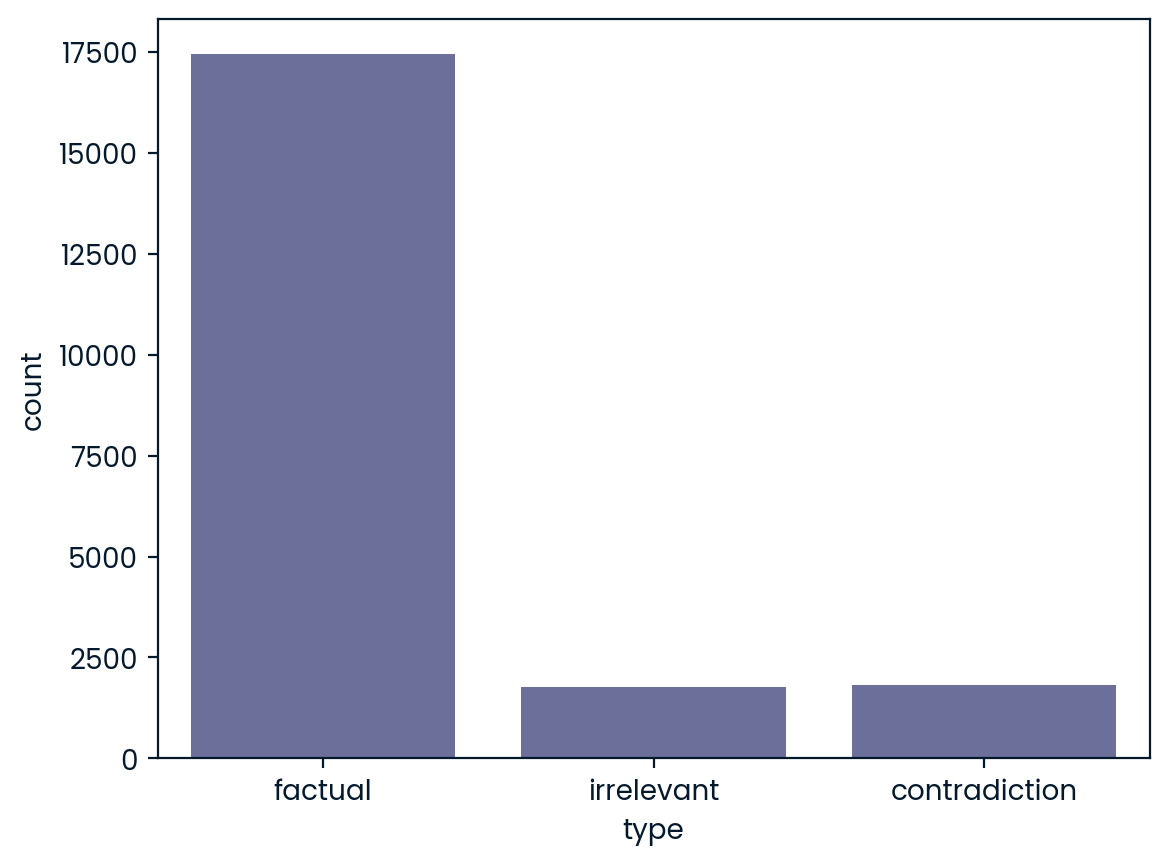

In [72]:
# check distribution of the prediction classes

sns.countplot(data = train_df, x = 'type')

train_df['type'].value_counts()

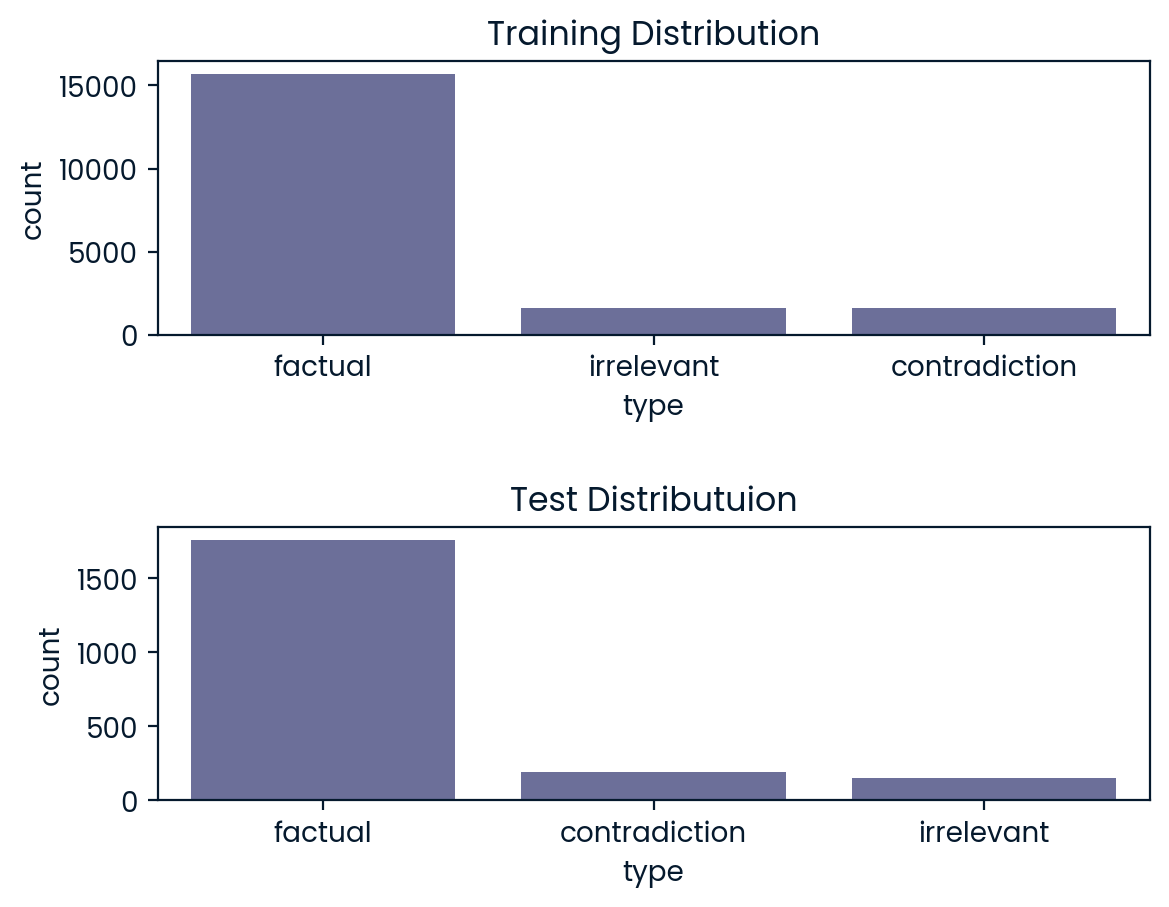

In [73]:
np.random.seed(5)

# note we drop type and type_nums later from X

X = train_df.drop(labels = ['answer', 'context', 'question'], axis = 1)
y = train_df[['type', 'type_nums']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)



fig, ax = plt.subplots(2,1)

sns.countplot(data = pd.DataFrame(y_train), x = 'type', ax = ax[0]).set_title('Training Distribution')

sns.countplot(data = pd.DataFrame(y_test), x = 'type', ax = ax[1]).set_title('Test Distributuion')

plt.subplots_adjust(hspace = 0.7)
plt.show()

In [74]:
# drop target columns from X and non-numeric type from y

X_train = X_train.drop(labels = ['type', 'type_nums'], axis = 1)
X_test = X_test.drop(labels = ['type', 'type_nums'], axis = 1)

y_train = y_train.drop(labels = 'type', axis = 1)
y_test = y_test.drop(labels = 'type', axis = 1)


In [75]:
# create neural network

class NNMultiClass(nn.Module):
    '''
    MultiClass classification neural network for numeric inputs. 
    
    Inherits from nn.Module.

    Attributes:
    ------------
        input_layer: a scaling up from 16 dimensions to 20 through linear transformation of the form aT + b, activated by ReLU for each element of the matrix: x = max(0, x). 

        hl1: hidden layer 1 scales up from 20 to 30 dimensions. 

        hl2: hidden layer 2 scales the dimension down from 30 to 3 incrementially.

        output_layer: softmax to ensure values can be interpreted as probabilities. 
    '''
    
    def __init__(self):
        super().__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU()
        )

        self.hl1 = nn.Sequential(
            nn.Linear(20, 30),
            nn.ELU(),
            nn.Dropout(0.2),
        )

        self.hl2 = nn.Sequential(
            nn.Linear(30, 15),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(15, 5),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(5, 3),
            nn.ReLU()
        )

        self.output_layer = nn.Softmax()

    def forward(self, x):
        '''
        Passes the data into the model and returns the probabilities of each class. 

        Parameters:
            self: self.
            x (nn.tensor): data to make predictions on.

        Returns:
        x (list[int]): probabilities of each class. 
        '''
            
        x = self.input_layer(x)
        x = self.hl1(x)
        x = self.hl2(x)
        x = self.output_layer(x)
            
        return x


In [76]:
# define focal loss criterion to emphasise the minority classes

import torch.nn.functional as F

class FocalLoss(nn.Module):
    '''
    Focal Loss criterion to improve convergence during training. 

    Inherits from nn.Module. 

    Attributes:
    ------------
    alpha: class weights for weight-balanced focal loss.

    gamma: power to which loss is evaluated - affects rate of convergence of loss.

    num_classes: number of labels for multiclass classification.
    '''
    
    def __init__(self, alpha: list[float] = None, gamma: int = None, num_classes = 3):
        super(FocalLoss, self).__init__()

        self.alpha = torch.tensor(alpha, dtype = torch.float32)
        self.gamma = gamma
        self.num_classes = num_classes

    def forward(self, input, target): 

        # select the correct weight based on target
        alpha_t = self.alpha[torch.argmax(target)]

        # reshape input and target
        i = input.reshape(-1)
        t = target.reshape(-1)

        # asign i or 1 - i as the probability based on softmax output
        p = torch.where(t >= 0.5, i, 1 - i)

        # find logp loss making sure p is not too close to 0 or 1
        logp = - torch.log(torch.clamp(p, 1e-6, 1 - 1e-6))

        # find focal loss with class weight balance
        loss = alpha_t * logp * ((1 - p) ** self.gamma) 

        # sum over batches and return
        loss = num_classes * loss.mean()
        return loss

In [77]:
# calculate class weights to correct the class imbalances

sols = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
counts = []

for i in sols: 
    counter = 0
    
    for j in y_train.index:
        if y_train['type_nums'][j] == i:
            counter += 1

    counts.append(counter)

class_counts = np.array(counts)
num_classes = len(class_counts)
total_count = len(y_train)

class_weights = []

for count in class_counts:
    
    weight = 1 / (count / total_count) 
    class_weights.append(weight / 100 + 0.8)


class_weights


[np.float64(0.9162039312039313),
 np.float64(0.8120719800906133),
 np.float64(0.9168499073502162)]

In [78]:
# convert X,y to tensors for training and create a data loader object 

#training set to tensor

X_train_tensor = torch.tensor(X_train.values, dtype = torch.float32)
y_train_tensor = torch.tensor([y_train.values[i][0] for i in range(0, len(y_train))], dtype = torch.float32)


#test set to tensor

X_test_tensor = torch.tensor(X_test.values, dtype = torch.float32)
y_test_tensor = torch.tensor([y_test.values[i][0] for i in range(0, len(y_test))], dtype = torch.float32)

#create dataloaders

dataloader_train = DataLoader(list(zip(X_train_tensor, y_train_tensor)), shuffle = False)

dataloader_test = DataLoader(list(zip(X_test_tensor, y_test_tensor)), shuffle = False)


#print to check data
print(X_train_tensor[5])

print(y_train_tensor[5])

for i, j in dataloader_train:
    print(i, j)
    break


for i, j in dataloader_test:
    print(i, j)
    break


tensor([2.6573e+01, 1.8421e+01, 6.9322e-01, 0.0000e+00, 2.5000e+01, 0.0000e+00,
        1.1000e+01, 7.8000e+01, 1.4103e-01, 2.0000e+00, 8.9000e+01, 2.2472e-02,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 4.6000e+01, 1.0000e+00])
tensor([0., 0., 1.])
tensor([[ 32.7985,  42.4229,   1.2934,   7.0000,  16.0000,   0.4375,   9.0000,
          34.0000,   0.2647,  13.0000,  36.0000,   0.3611,   7.0000,   1.0000,
           0.0000, 130.0000,   1.0000]]) tensor([[0., 1., 0.]])
tensor([[2.3284e+01, 2.9555e+01, 1.2694e+00, 8.0000e+00, 8.0000e+00, 1.0000e+00,
         5.0000e+00, 9.1000e+01, 5.4945e-02, 9.0000e+00, 8.7000e+01, 1.0345e-01,
         5.0000e+00, 1.0000e+00, 0.0000e+00, 1.0200e+02, 1.0000e+00]]) tensor([[0., 1., 0.]])


In [79]:
# optimiser and training 

model = NNMultiClass()

criterion = FocalLoss(alpha = class_weights, gamma = 2)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.5)

for epoch in range(1, 41):
    running_loss = 0.0
    for x_vals, y_vals in dataloader_train:
        optimizer.zero_grad()
        outputs = model(x_vals)
        loss = criterion(outputs, y_vals)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(X_train)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")
 

Epoch 5, Loss: 0.1382
Epoch 10, Loss: 0.1336
Epoch 15, Loss: 0.1282
Epoch 20, Loss: 0.1247
Epoch 25, Loss: 0.1225
Epoch 30, Loss: 0.1220
Epoch 35, Loss: 0.1263
Epoch 40, Loss: 0.1184


In [80]:
# test accuracy, precision, and recall

acc = Accuracy(task = 'multilabel', num_labels = 3)
prec = Precision(task = 'multilabel', num_labels = 3)
rec = Recall(task = 'multilabel', num_labels = 3)

incorrect_preds = {'0' : 0, '1' : 0, '2' : 0}

model.eval()

with torch.no_grad():
    for x_vals, y_vals in dataloader_test:
        output = model(x_vals)
        
        classification = torch.tensor([1 if i == torch.argmax(output) else 0 for i in range(3)], dtype = torch.float32).unsqueeze(0)
        
        acc(classification, y_vals)
        prec(classification, y_vals)
        rec(classification, y_vals)


        if torch.argmax(classification) != torch.argmax(y_vals):
            incorrect_preds[str(int(torch.argmax(y_vals)))] += 1
            print(output, classification, y_vals)
        

tensor([[0.2695, 0.6327, 0.0978]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.1853, 0.7428, 0.0719]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.1522, 0.7738, 0.0740]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.0863, 0.8396, 0.0740]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.0731, 0.8563, 0.0706]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.2536, 0.6731, 0.0733]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.2105, 0.7196, 0.0700]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.2633, 0.3536, 0.3831]]) tensor([[0., 0., 1.]]) tensor([[1., 0., 0.]])
tensor([[0.1668, 0.7607, 0.0725]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.2528, 0.6755, 0.0717]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.2204, 0.7096, 0.0699]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.3013, 0.5514, 0.1473]]) tensor([[0., 1., 0.]]) tensor([[1., 0., 0.]])
tensor([[0.1386, 0.7849, 0.0

In [81]:
print('accuracy is ', float(acc.compute()))

print('precision is ', float(prec.compute()))

print('recall is ', float(rec.compute()))

print('f1 score is ', 2 * (float(prec.compute()) * float(rec.compute()) ) / (float(prec.compute()) + float(rec.compute())) )
                                                                           
print(incorrect_preds)

accuracy is  0.9679822325706482
precision is  0.9519733786582947
recall is  0.9519733786582947
f1 score is  0.9519733786582947
{'0': 85, '1': 12, '2': 4}


## 💪 Competition challenge

Create a report here in DataLab that covers the following:
1. Your EDA and machine learning process using the `data/train.json` file.
2. Complete the `data/test.json` file by predicting the `type` of answer for each question (2000 total). The `data/test.json` file also has an `ID` column, which uniquely identifies each row.


## ✅ Submission Instructions:

* First, submit your DataLab workbook using the button in the top right corner.
* Then, submit your predictions as a **.json file** via [this form](https://forms.gle/hKFHqPkaeQkfAx4v7).
* The structure of the file should not be altered, and should include the IDs and predicted answer `type`.
*  Only one team member needs to submit. List the **academic** emails of **all** the team members in the submission form.




## 🧑‍⚖️ Judging criteria

Your submission will be scored using a custom weighted confusion matrix to account for cost-based priorities. Each class receives an equal weighting to calculate your overall prediction performance. Thus, factual prediction score counts for 33.3%, contradiction classification for 33.3%, and irrelevant for 33.3%.

Your classification evaluation on the test set will be ranked among all teams in the competition. A total of 6000 points (34.60% of the total amount of points of the Data4Good challenge) can be earned by successfully submitting the competition.

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights. 
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error.

## ⌛️ Time is ticking. Good luck!